# Project Update 2

Second update for Cases Study project, this update focuses on following suggestions and showing progress with the last next steps we had in the previous update.

## Pending tasks

From the previous update the pending tasks were:

1. Classify more tweets: We were able to download more tweets from the tweeter API, but we are still short with the manual classification, as we prioritized using the transformers library which already has some neat pre-trained models.

2. Run an SVM classifier for the tweets: The SVM classifier was not trained or executed on its own, as we believe it's better to invest time in the actual problem that we want to solve, that is to show the sentiment analysis related to airlines in an easier and more meaningful way through dashboards.

3. First dashboard displaying the collected data: We were able to put a dashboard together with the new data

## Required SetUp

The following setup is needed to install the transformers library, only macOS instructions are available at the moment.

### macOS

Installs the Rust compiler to build the tokenizers library

```shell
brew install rustup-init
```

Add new env config to zshrc or equivalent

```shell
echo "source ~/.cargo/env" >> ~/.zshrc
```

_Source: [Installation Error - Failed building wheel for tokenizers](https://github.com/huggingface/transformers/issues/2831#issuecomment-1001437376)_

Install tensorflow in macOS by following the [official Apple documentation](https://developer.apple.com/metal/tensorflow-plugin/)[1].

Finish by installing the `transformers` library in the created virtual environment.

Installs the transformers library for access to the models

```shell
pip install transformers
```

[1]: [Could not find a version that satisfies the requirement tensorflow](https://stackoverflow.com/questions/48720833/could-not-find-a-version-that-satisfies-the-requirement-tensorflow)

In [1]:
from transformers import pipeline

/Users/eduardo@yalo.com/miniforge3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
classifier = pipeline('sentiment-analysis')
classifier('We are very happy to introduce pipeline to the transformers repository.')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-07-27 18:49:38.196665: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-27 18:49:38.196806: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


[{'label': 'POSITIVE', 'score': 0.9996980428695679}]

Wit the above classification of a sample message obtained from the hugging face site, we have successfully configured the classifier to run the model against the available twits we have. 

Below some of the available tweets in the original data set are ran through the model to test it with data now scoped to the domain of airlines.

In [4]:
import pandas as pd

In [5]:
old_tweets = pd.read_csv('../../archive/Tweets.csv')

In [11]:
row = old_tweets.iloc[0, ]
tfm_result = classifier(row.text)

In [13]:
tfm_result

[{'label': 'POSITIVE', 'score': 0.8633630275726318}]

In [16]:
print(f"Original confidence %f vs %f" % (row.airline_sentiment_confidence, tfm_result[0]['score']))

print ("Original label %s vs new label %s" % (row.airline_sentiment, tfm_result[0]['label'].lower()))

Original confidence 1.000000 vs 0.863363
Original label neutral vs new label positive


It's now possible to compare the previous and new labels to check how those may change by using the transformers model vs what the existing labeled data already has.

In [19]:
old_tweets.shape

(14640, 15)

In [7]:
for index, row in old_tweets.sample(n=10).iterrows():
    tfm_result = classifier(row.text)[0]
    old_tweets.loc[index, 'tfm_classification'] = tfm_result['label']
    old_tweets.loc[index, 'tfm_score'] = tfm_result['score']


In [8]:
old_tweets[~old_tweets['tfm_classification'].isna()][['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'tfm_classification', 'tfm_score']]

,tweet_id,airline_sentiment,airline_sentiment_confidence,tfm_classification,tfm_score
925,570009743160254464,neutral,1.0000,NEGATIVE,0.998697
1157,569911515106582528,negative,1.0000,NEGATIVE,0.998926
2680,568958107205783554,negative,1.0000,NEGATIVE,0.999817
3423,568454386617356291,negative,1.0000,NEGATIVE,0.999613
4877,569670671695011840,neutral,0.6801,NEGATIVE,0.991647
5409,569132950006185985,negative,1.0000,NEGATIVE,0.997139
6673,567737625637687296,neutral,0.6619,NEGATIVE,0.984052
8107,568782407698149376,positive,1.0000,NEGATIVE,0.687430
9960,569600720254541824,negative,1.0000,NEGATIVE,0.998992
10086,569541291467522048,negative,1.0000,NEGATIVE,0.999313


The default model in use is [`distilbert-base-uncased-finetuned-sst-2-english`](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english), as we can see above the model only has `POSITIVE` and `NEGATIVE` classifications, or at least with the above tests, there's no neutral classification, at least not with the sample above.

Let's try now with one of the most downloaded models available at Hugging Face, the [`cardiffnlp/twitter-xlm-roberta-base-sentiment`](https://huggingface.co/cardiffnlp/twitter-xlm-roberta-base-sentiment) (XLM-Roberta model).

The step below requires to have the `sentencepiece` package installed. The steps below were followed to make it run on a Mac.

```shell
brew install cmake
wget https://files.pythonhosted.org/packages/aa/71/bb7d64dcd80a6506146397bca7310d5a8684f0f9ef035f03affb657f1aec/sentencepiece-0.1.96.tar.gz
brew install pkgconfig
pip -v install  sentencepiece-0.1.96.tar.gz
```

After the above steps, the kernel must be restarted for the model to load properly.

_Sources followed:_
* [Add Mac M1 Compatibility](https://github.com/google/sentencepiece/issues/608#issuecomment-1158367943)
* [ValueError: Couldn't instantiate the backend tokenizer while loading model tokenizer #9750](https://github.com/huggingface/transformers/issues/9750#issuecomment-766862107)

In [3]:
model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
cdiff_model = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)

All model checkpoint layers were used when initializing TFXLMRobertaForSequenceClassification.

All the layers of TFXLMRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForSequenceClassification for predictions without further training.


In [9]:
for index, row in old_tweets[~old_tweets['tfm_classification'].isna()].iterrows():
    rbt_result = cdiff_model(row.text)[0]
    old_tweets.loc[index, 'roberta_classification'] = rbt_result['label']
    old_tweets.loc[index, 'roberta_score'] = rbt_result['score']


In [10]:
old_tweets[~old_tweets['tfm_classification'].isna()][['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'tfm_classification', 'tfm_score', 'roberta_classification', 'roberta_score']]

,tweet_id,airline_sentiment,airline_sentiment_confidence,tfm_classification,tfm_score,roberta_classification,roberta_score
925,570009743160254464,neutral,1.0000,NEGATIVE,0.998697,Negative,0.515928
1157,569911515106582528,negative,1.0000,NEGATIVE,0.998926,Negative,0.925066
2680,568958107205783554,negative,1.0000,NEGATIVE,0.999817,Negative,0.940675
3423,568454386617356291,negative,1.0000,NEGATIVE,0.999613,Negative,0.941453
4877,569670671695011840,neutral,0.6801,NEGATIVE,0.991647,Neutral,0.655823
5409,569132950006185985,negative,1.0000,NEGATIVE,0.997139,Negative,0.837570
6673,567737625637687296,neutral,0.6619,NEGATIVE,0.984052,Neutral,0.737134
8107,568782407698149376,positive,1.0000,NEGATIVE,0.687430,Positive,0.884003
9960,569600720254541824,negative,1.0000,NEGATIVE,0.998992,Negative,0.839267
10086,569541291467522048,negative,1.0000,NEGATIVE,0.999313,Negative,0.941510


It's interesting to see how the XLM-Roberta model closely matches the manually classified tweets above, more specifically the neutral tweets, which could not be obtained directly from the first model we tried.

## Sentiment Analysis on fresh tweets

Below some sample tweets are obtained from the Twitter API to run them through the classifier.

From the original data we can check which airlines are available to get an idea of how we should retrieve data from the API.

In [13]:
old_tweets[['airline', 'tweet_id']].groupby('airline', as_index=False).count().sort_values('tweet_id', ascending=False)

,airline,tweet_id
4,United,3822
3,US Airways,2913
0,American,2759
2,Southwest,2420
1,Delta,2222
5,Virgin America,504


The code from this section onwards requries the [`searchtweets-v2`](https://pypi.org/project/searchtweets-v2/) library. Make sure to have it installed in your env.

In [2]:
from searchtweets import ResultStream, gen_request_parameters, load_credentials

In [17]:
search_args = load_credentials("./.twitter_keys.yaml", yaml_key="search_tweets_v2",env_overwrite=False)

In [31]:
query = gen_request_parameters("@United", results_per_call=10, granularity=None, tweet_fields='created_at')
print(query)

{"query": "@United", "max_results": 10, "tweet.fields": "created_at"}


In [32]:
rs = ResultStream(request_parameters=query, max_results=10, max_pages=1, **search_args)

In [33]:
tweets = list(rs.stream())

In [39]:
tweets[2]

{'data': [{'created_at': '2022-07-07T22:28:20.000Z',
   'id': '1545172895369859072',
   'text': 'RT @IBJIYONGI: So the universe is making up for the scary landing situation — if you’re in the @united terminal at SFO, stop by Compass Boo…'},
  {'created_at': '2022-07-07T22:27:27.000Z',
   'id': '1545172673135017984',
   'text': 'RT @Angels: Baltimore ✈️✈️✈️✈️✈️!!!\n\n✈️ x @united https://t.co/czqn63jebQ'},
  {'created_at': '2022-07-07T22:25:17.000Z',
   'id': '1545172126403026946',
   'text': "RT @united: Good things come to those who don't wait. Download the United app to save time at the airport."},
  {'created_at': '2022-07-07T22:23:36.000Z',
   'id': '1545171700840632323',
   'text': 'RT @HuffmanLabDU: 13/ Interesting that @United reworked standard flight attendant speech to announce proud use of “antimicrobial surfaces,”…'},
  {'created_at': '2022-07-07T22:22:25.000Z',
   'id': '1545171403439108096',
   'text': '@RyanPaevey @united Were you there when the plane was built? No? Late!

Let's see the above in a nicer way by creating a data frame from the data obtained. We can see that the response has all the tweets inside a `data` field, that can be merged into a single list, which will be used to then load a data frame with it.

In [40]:
united_sample = []
for tg in tweets:
    united_sample.extend(tg['data'])

In [41]:
united_sample_df = pd.DataFrame(united_sample)

In [42]:
united_sample_df

,created_at,id,text
0,2022-07-07T22:58:31.000Z,1545180489790529536,@jonathangooda @Cheryl_Searle @carolyn_mcglynn...
1,2022-07-07T22:57:41.000Z,1545180281300307968,@DocReggies @tkausiyo @united Sadly abva afa.
2,2022-07-07T22:57:19.000Z,1545180188484554754,@RyanPaevey @united Happened to me too once on...
3,2022-07-07T22:55:13.000Z,1545179659746304005,@tkausiyo @TapiwaMunjoma @united 🤣🤣🤣
4,2022-07-07T22:53:04.000Z,1545179118639099904,@united What are United’s stats against a peer...
...,...,...,...
495,2022-07-07T16:00:56.000Z,1545075402158137345,@Shrekgotthepha1 @united Some bih eating what ...
496,2022-07-07T16:00:08.000Z,1545075201909690370,@haleysnothere21 @united RT full eyes trueblue...
497,2022-07-07T15:59:50.000Z,1545075124533182467,@united screen won’t let me add another travel...
498,2022-07-07T15:57:56.000Z,1545074645367263234,@sell_arte_sell @Angels @united Buses were full.


Saving them for posterity, to prevent us from having to query the API again.

In [43]:
# united_sample_df.to_csv('./fresh_data/united_sample_070722.csv')

Let's now run it through the classifier.

In [90]:
import time

In [93]:
def roberta_classifies(df, classifier=cdiff_model):
    classification_times = []
    for index, row in df.iterrows():
        start_time = time.time()
        
        rbt_result = classifier(row.text)[0]
        
        end_time = time.time()
        
        classification_times.append(end_time-start_time)
        
        df.loc[index, 'classification'] = rbt_result['label']
        df.loc[index, 'score'] = rbt_result['score']

    return classification_times, df


In [46]:
roberta_classifies(united_sample_df)

In [47]:
united_sample_df

,created_at,id,text,classification,score
0,2022-07-07T22:58:31.000Z,1545180489790529536,@jonathangooda @Cheryl_Searle @carolyn_mcglynn...,Neutral,0.676336
1,2022-07-07T22:57:41.000Z,1545180281300307968,@DocReggies @tkausiyo @united Sadly abva afa.,Negative,0.879338
2,2022-07-07T22:57:19.000Z,1545180188484554754,@RyanPaevey @united Happened to me too once on...,Negative,0.825423
3,2022-07-07T22:55:13.000Z,1545179659746304005,@tkausiyo @TapiwaMunjoma @united 🤣🤣🤣,Neutral,0.544360
4,2022-07-07T22:53:04.000Z,1545179118639099904,@united What are United’s stats against a peer...,Negative,0.948139
...,...,...,...,...,...
495,2022-07-07T16:00:56.000Z,1545075402158137345,@Shrekgotthepha1 @united Some bih eating what ...,Negative,0.951184
496,2022-07-07T16:00:08.000Z,1545075201909690370,@haleysnothere21 @united RT full eyes trueblue...,Neutral,0.439411
497,2022-07-07T15:59:50.000Z,1545075124533182467,@united screen won’t let me add another travel...,Negative,0.769451
498,2022-07-07T15:57:56.000Z,1545074645367263234,@sell_arte_sell @Angels @united Buses were full.,Neutral,0.486825


In [48]:
united_sample_df[['id', 'classification']].groupby('classification', as_index=False).count().sort_values('id', ascending=False)

,classification,id
0,Negative,224
1,Neutral,148
2,Positive,128


In [73]:
def display_by_label(df, label: str, score=0.8):
    with pd.option_context('display.max_colwidth', None):
        display(df.loc[(df['score'] > score) & (df['classification'] == label)])

In [75]:
display_by_label(united_sample_df, 'Negative')

,created_at,id,text,classification,score
1,2022-07-07T22:57:41.000Z,1545180281300307968,@DocReggies @tkausiyo @united Sadly abva afa.,Negative,0.879338
2,2022-07-07T22:57:19.000Z,1545180188484554754,"@RyanPaevey @united Happened to me too once on my return ✈️ from Johannesburg. I did pre check in,arrived +3 hrs early. I got bumped; agent told me he couldn’t check in my bag yet,to step aside while he checked in other passengers?!!😡 No explanation. I lost my💩😤.I spoke to manager &amp; got on my✈️😊",Negative,0.825423
4,2022-07-07T22:53:04.000Z,1545179118639099904,"@united What are United’s stats against a peer, like Delta, instead of a low cost carrier, in a comparable market like NYC? EWR, LGA, JFK. Comparing yourself to Southwest seems to be a disservice to United.",Negative,0.948139
7,2022-07-07T22:44:56.000Z,1545177070992445441,@BaconGrillin123 @united It wasn't. @united has terrible customer service =),Negative,0.861602
13,2022-07-07T22:35:12.000Z,1545174619946090497,"@KatLaRonde @united @united Why? Why do you say boarding begins at 5:54, for it to be 6:35 and the boarding hasn’t started yet? What’s the point of having an app if the info in it is not correct? 1190",Negative,0.815759
...,...,...,...,...,...
473,2022-07-07T16:23:29.000Z,1545081075247919105,RT @VeronicaSam13: I told y'all so! This is a concerted effort to embarrass Biden's FAA appointee and Buttgieg!!\nWe see you @united !! http…,Negative,0.915078
475,2022-07-07T16:22:14.000Z,1545080760360734720,@united Wade through fecal matter and needles in craphole SF to get to your new destination of covid concentration camps? So tempting but that is a hard pass for me.,Negative,0.884115
483,2022-07-07T16:11:21.000Z,1545078023547912192,@united #unitedairlines \n\nI have called and message United for maybe over 5 hours worth of time. The file ref number given by United is too many digits to fit on your claims page. Why is this so hard?,Negative,0.882415
494,2022-07-07T16:01:34.000Z,1545075559897747456,@united worst experience in an airport or with airlines ever! Almost 9 hours of continuous delays only to cancel flight. No vouchers or food offered until flight was being canceled. Every answer vague and intentionally misleading. After 16 hours we finally were able to fly,Negative,0.953092


Before moving on, let's store our classified tweets, just to prevent us from loosing the data for further analysis.

In [76]:
# united_sample_df.to_csv('./classified_data/united_sample_070722_sa_classified.csv')

Let's now generalize the tweets search to allow us to get more tweets as we need it.

> ⚠️ For some reason, it looks like the twitter search v2 client is broken and is actually not returning the right format for the values, it should be directly returning the tweets, but it's not doing that and the returned payload is wrapped.

In [83]:
from datetime import datetime

In [107]:
# This is usually only set once, although, it can change depending on the endpoint we want to reach, as defined in the yaml_key
search_args = load_credentials("./.twitter_keys.yaml", yaml_key="search_tweets_v2",env_overwrite=False)

def search_tweets(text_query: str, search_args, results_per_call=10, max_results=10):
    """
    Returns a tweet stream for the provided text query, it can then be iterated to retrieve each individual tweet.
    Args:
        text_query (str): The topic of interest or text to search for.
        search_args (dict): Arguments needed to authenticate.
    Returns:
        a result stream iterable/generator.
    """
    query = gen_request_parameters(text_query, results_per_call=results_per_call, granularity=None, tweet_fields='created_at')
    rs = ResultStream(request_parameters=query, max_results=max_results, max_pages=1, **search_args)
    return rs.stream()

def merge_stream_results(tweets):
    sample = []
    for tg in tweets:
        sample.extend(tg['data'])

    return pd.DataFrame(sample)

def get_date_suffix():
    now = datetime.now() 
    return now.strftime("%d%m%Y_%H%M%S")

def get_fresh_classified_tweets(handlers: list, search_args: dict, *args):
    for h in handlers:
        print(f"Getting fresh tweets for {h}...")

        tws_stream = search_tweets(f"@{h}", search_args, *args)

        df = merge_stream_results(tws_stream)

        f_suffix = get_date_suffix()

        df.to_csv(f'./fresh_data/{h.lower()}_sample_{f_suffix}.csv')

        c_times, df_class = roberta_classifies(df)

        df_class.to_csv(f'./classified_data/{h.lower()}_sample_{f_suffix}_sa_classified.csv')

        c_times_df = pd.DataFrame(c_times)

        c_times_df.to_csv(f'./classification_times/{h.lower()}_{suffix}.csv', index=False)

        print("Done!")


Below some of the top US and Canada airlines are considered for the retrieval of tweets. The original dataset was revised to remove those airlines no longer in operation due to merging or buyouts by other companies.

In [78]:
airlines_tw_handlers = ["United", "AmericanAir", "SouthwestAir", "Delta", "alaskaair", "AirCanada", "WestJet", "airtransat", "porterairlines", "FlairAirlines"]

In [108]:
get_fresh_classified_tweets(airlines_tw_handlers[4:], search_args)

Getting fresh tweets for alaskaair...
Done!
Getting fresh tweets for AirCanada...
Done!
Getting fresh tweets for WestJet...
Done!
Getting fresh tweets for airtransat...
Done!
Getting fresh tweets for porterairlines...
Done!
Getting fresh tweets for FlairAirlines...
Done!


## Recovery of results

Loading and classifying intermediate results

In [94]:
df_part = pd.read_csv('./fresh_data/americanair_sample_07072022.csv')

c_time, df_class = roberta_classifies(df_part)

In [95]:
c_times_df = pd.DataFrame(c_time)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

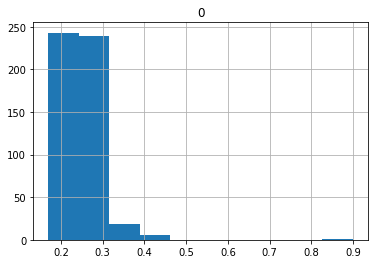

In [97]:
c_times_df.hist()

From the Above, it looks like it can take up to 1s to classify a text.

In [99]:
suffix = get_date_suffix()
df_class.to_csv(f'./classified_data/americanair_sample_{suffix}_sa_classified.csv')

In [101]:
c_times_df.to_csv(f'./classification_times/americanair_{suffix}.csv', index=False)

## References

* [pandas create new column based on values from other columns / apply a function of multiple columns, row-wise](https://stackoverflow.com/a/46570641/3211335)
* [Creating an empty Pandas DataFrame, then filling it?](https://stackoverflow.com/a/56746204/3211335)
* [How to iterate over rows in a DataFrame in Pandas](https://stackoverflow.com/a/16476974/3211335)